In [31]:
from carbon.helpers import PathGenerator
from carbon.helpers.pdread import *
from math import sin, cos, pi
import os
from math import sqrt, exp, log
from datetime import timedelta as _timedelta, datetime as _datetime
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = [8,4]

# Generate Data
## Generate big random path samples

In [32]:
FILENAME = lambda sig, mu: f"RAN-{int(sig*100):05d}-{int(mu*100):04d}-NEW"
FILENAME(sig=0.2, mu=0)

'RAN-00020-0000-NEW'

In [33]:
FILENAME = None    # comment out to generate paths

In [34]:
if not FILENAME is None:
    print("Generating paths")
    for sig in (0.05, 0.1, 0.2, 0.5, 0.75, 1):
        df = PathGenerator(sig=sig).pathdf(1000)
        df.to_csv(FILENAME(sig=sig, mu=0)+".csv.gz", index=False, compression="gzip")
        #df.to_csv(FILENAME(sig=sig, mu=0)+".csv", index=False)
        df.to_pickle(FILENAME(sig=sig, mu=0)+".pickle")
else:
    print("Not generating paths")

Not generating paths


In [35]:
!ls *.pickle

COS.pickle        RAN-010-00.pickle RAN-050-00.pickle RAN-100-00.pickle
RAN-005-00.pickle RAN-020-00.pickle RAN-075-00.pickle RAN-SIGMU.pickle


In [36]:
!ls *.csv.gz

zsh:1: no matches found: *.csv.gz


In [37]:
!ls *.csv

zsh:1: no matches found: *.csv


## Generate single random path repo

In [38]:
FILENAME2 = lambda mu: f"RAN-SIGMU"
FILENAME2 = None

In [39]:
dfs = {
    (sig,mu): PathGenerator(sig=sig, mu=mu).pathdf(10)
    for mu in [0,0.05,0.2]
    for sig in (0.01, 0.05, 0.25, 0.5, 0.75, 1)
}
df_aggr = pd.concat(dfs.values(), axis=1)
#df.to_csv(FILENAME(sig=sig, mu=0)+".csv.gz", index=False, compression="gzip")
#df.to_csv(FILENAME(sig=sig, mu=0)+".csv", index=False)
if not FILENAME2 is None:
    df_aggr.to_pickle(FILENAME2()+".pickle")
df_aggr

,p001-00-000,p001-00-001,p001-00-002,p001-00-003,p001-00-004,p001-00-005,p001-00-006,p001-00-007,p001-00-008,p001-00-009,...,p100-20-000,p100-20-001,p100-20-002,p100-20-003,p100-20-004,p100-20-005,p100-20-006,p100-20-007,p100-20-008,p100-20-009
datetime,,,,,,,,,,,,,,,,,,,,,
2020-01-01 00:00:00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2020-01-02 19:49:48,99.932297,99.936489,100.074309,100.061088,100.006151,100.029559,100.018310,99.985905,100.048389,99.787840,...,94.136612,99.881200,108.008239,94.038795,99.478731,101.173489,106.272111,101.367865,107.394251,97.899522
2020-01-04 15:39:36,99.910670,99.870933,100.051238,100.113299,100.138271,100.058138,100.017737,99.953788,99.965360,99.726716,...,88.023590,86.306996,95.114025,99.462508,102.103271,97.594594,102.248092,96.012813,110.372975,98.369176
2020-01-06 11:29:24,100.020490,99.850556,100.106580,100.041985,100.017202,100.115459,100.167998,100.025189,99.992513,99.729573,...,90.518794,82.039280,93.412836,96.261317,93.590661,102.863808,110.827150,96.546852,111.253415,103.684902
2020-01-08 07:19:12,99.874744,99.897949,99.931754,100.012234,100.096490,100.086932,100.123585,99.945363,100.036044,99.665835,...,102.822400,77.390372,87.801198,91.288091,91.608284,107.303052,120.064391,88.844512,111.161560,92.657119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23 22:40:48,100.117956,100.451269,100.357436,100.670108,99.898803,101.378961,99.618962,98.374442,100.277170,99.901029,...,31.275080,9.892411,25.941822,272.149224,742.018842,115.431015,226.700479,113.249253,89.241185,78.057702
2020-12-25 18:30:36,100.197634,100.486696,100.260779,100.650530,99.912323,101.485658,99.717224,98.400026,100.175578,99.835317,...,35.436803,10.323024,23.987687,251.173802,758.673449,127.555373,217.082632,105.314641,81.979074,80.688363
2020-12-27 14:20:24,100.064757,100.433349,100.248041,100.636589,99.957246,101.550366,99.681928,98.384960,100.260060,99.783951,...,34.332283,10.597010,25.767203,240.808918,761.039967,124.411994,205.948420,101.282776,85.236454,73.825936


In [40]:
[ df_aggr.columns[i*10] for i in range(6) ]

['p001-00-000',
 'p005-00-000',
 'p025-00-000',
 'p050-00-000',
 'p075-00-000',
 'p100-00-000']

In [41]:
[ df_aggr.columns[i*10+60] for i in range(6) ]

['p001-05-000',
 'p005-05-000',
 'p025-05-000',
 'p050-05-000',
 'p075-05-000',
 'p100-05-000']

In [42]:
[ df_aggr.columns[i*10+61] for i in range(6) ]

['p001-05-001',
 'p005-05-001',
 'p025-05-001',
 'p050-05-001',
 'p075-05-001',
 'p100-05-001']

In [43]:
!ls

COS.pickle        RAN-005-00.pickle RAN-100-00.pickle download
Display.ipynb     RAN-010-00.pickle RAN-SIGMU.pickle  fls.py
Display.py        RAN-020-00.pickle __pycache__
Generate.ipynb    RAN-050-00.pickle carbon
Generate.py       RAN-075-00.pickle charts


In [44]:
#!rm RAN-AGGR.pickle

In [45]:
# fns = [fn for fn in os.listdir() if fn[:3]=="RAN"]
# fns = ['RAN-005-00.pickle',
#  'RAN-010-00.pickle',
#  'RAN-100-00.pickle',
#  'RAN-075-00.pickle',
#  'RAN-020-00.pickle',
#  'RAN-050-00.pickle']
# # for fn in fns:
# #     df = pd.read_pickle(fn)
# #     del df["time"]
# #     df = df.set_index("datetime")
# #     df.to_pickle(fn)
# pd.read_pickle(fns[2])

## Generate Sin, Cos paths

In [46]:
PathGenerator.DEFAULTS

{'mu': 0,
 'sig': 0.5,
 's0': 100,
 'time': 1,
 'N': 200,
 'startdt': (2020, 1, 1),
 'numpaths': 100,
 'colname': 'p{sig100:03d}-{mu100:02d}-{ix:03d}'}

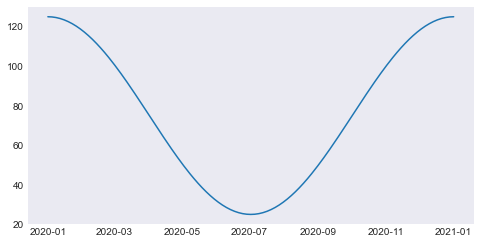

In [47]:
start_dt=pd.Timestamp("2020-01-01")
end_dt=pd.Timestamp("2021-01-01")
nsteps = 200
delt = (end_dt-start_dt)/nsteps
x = lambda n: 2*pi*n/nsteps
t = lambda n: start_dt + delt*n
p = lambda i, f: 75+50*cos((f+1)*x(i))
assert x(nsteps) == 2*pi
assert t(nsteps) == end_dt


ix = 10
time = np.array([t(i) for i in range(nsteps+1)])

dfs = [
    pd.DataFrame(
        np.array([p(i,ix) for i in range(nsteps+1)]), 
        index=time, 
        columns=[f"p-a-{ix:02d}"]
    )
for ix in range(10)
]
df_aggr = pd.concat(dfs, axis=1)
df_aggr.to_pickle("COS.pickle")
plt.plot(dfs[0])

In [48]:
p(100,5)

125.0

In [49]:
!ls

COS.pickle        RAN-005-00.pickle RAN-100-00.pickle download
Display.ipynb     RAN-010-00.pickle RAN-SIGMU.pickle  fls.py
Display.py        RAN-020-00.pickle __pycache__
Generate.ipynb    RAN-050-00.pickle carbon
Generate.py       RAN-075-00.pickle charts


## Data retrieval examples

In [50]:
fn = "COS.pickle"

In [51]:
pdcols(fn)

Index(['p-a-00', 'p-a-01', 'p-a-02', 'p-a-03', 'p-a-04', 'p-a-05', 'p-a-06',
       'p-a-07', 'p-a-08', 'p-a-09'],
      dtype='object')

In [52]:
ser=pdread(fn, "p-a-01")
ser

2020-01-01 00:00:00    125.000000
2020-01-02 19:55:12    124.901336
2020-01-04 15:50:24    124.605735
2020-01-06 11:45:36    124.114363
2020-01-08 07:40:48    123.429158
                          ...    
2020-12-24 16:19:12    123.429158
2020-12-26 12:14:24    124.114363
2020-12-28 08:09:36    124.605735
2020-12-30 04:04:48    124.901336
2021-01-01 00:00:00    125.000000
Name: p-a-01, Length: 201, dtype: float64

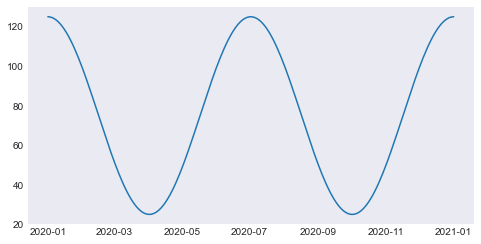

In [53]:
plt.plot(ser)

In [54]:
ser = pdread(fn, 0)
ser

2020-01-01 00:00:00    125.000000
2020-01-02 19:55:12    124.975328
2020-01-04 15:50:24    124.901336
2020-01-06 11:45:36    124.778098
2020-01-08 07:40:48    124.605735
                          ...    
2020-12-24 16:19:12    124.605735
2020-12-26 12:14:24    124.778098
2020-12-28 08:09:36    124.901336
2020-12-30 04:04:48    124.975328
2021-01-01 00:00:00    125.000000
Name: p-a-00, Length: 201, dtype: float64

In [55]:
ser.index[0]

Timestamp('2020-01-01 00:00:00')

In [56]:
pd.Timedelta(days=1)

Timedelta('1 days 00:00:00')